runtime: 7-8 minutes

# Final Project_Females' Dialogue Entropy_Hay



## Purpose
The aim of the project is to investigate the evolution of female characters' roles in movie industry throughout history. Due to a tremendous increase in women's enrollment in a wide range of industries, especially after WWII,I expect female character to take on a more critical role in show business. This project will investigate the trend between 1935 and 1955, before and after WWII, by analysis the entropy of females' dialogue. A further comparison between 1935-1955 and 1995-2010 will be made to see how females' roles has changed over the history. 

## Method
In general, characters with more active/critical roles have a higher speech complexity. Speech complexity refers to how complex or rich a dialogue is and is measured with a quantity known as 'entropy'. Entropy is mathematically formuated as $H(X) = -\sum p(x_i)log( p(x_i) )$, where $x_i$ would be an individual word, $p(x_i)$ is the probability of that word appearing in the text. Since we are calculating this form data, the probability is equal to the frequency.

As some genres [like action] prohibit or restrict the freedom of dialogue, only 'Romance' and 'Drama' are chosen in this project because these two promote the expression of feeling, concerns and etc. Movies within the genres of each year within the selected period are extracted, and only female characters of each movie are chosen for this project. 

The entropy of each female character will be calculated within each movie for each year, and the maximum and average entropy across all characters will be calculated to analyse data. 

### Datasets For Projects

The available datasets are listed below:
1. **Movie corpus data**. This corpus contains a large metadata-rich collection of fictional conversations extracted from raw movie scripts:
    - `220,579` conversational exchanges between `10,292` pairs of movie characters
    - involves `9,035` characters from `617` movies
    - in total `304,713` utterances
    - movie metadata included:
        - genres
        - release year
        - IMDB rating
        - number of IMDB votes
    - character metadata included:
        - gender (for `3,774` characters)
        - position on movie credits (`3,321` characters)


In [1]:
import pandas as pd # pandas usually used with alias pd

import matplotlib.pyplot as plt
# This is the method to make sure that plots appear directly in the notebook
%matplotlib inline
import numpy as np
import scipy.stats as stat

import pickle
import re 
import statistics
import math

In [2]:
#df_title: a dataframe containing information about movies, such as: movieID, year_of_production, titles, genres...

with open('./movie_title.pkl', 'rb') as f:
    df_title = pickle.load(f)
df_title.drop(['genres_x', 'movie_title'], axis='columns', inplace=True)
df_title.rename({'genres_y' : 'genres', 'title' : 'movie_title'}, axis='columns', inplace=True)

In [3]:
#df_character: a dataframe, which has characters' name, gender, characterID corresponding to each movie

df_character = pd.read_table(
    './movie_characters_metadata.txt',
    delimiter='\t',
    header=None,
    names=[
        'characterID',
        'character_name',
        'movieID',
        'movie_title',
        'gender',
        'position_in_credits'
    ]
)


In [4]:
#df_dialog: a dataframe containing characters' dialog, characters' name and ID, and corresponding movies

df_dialog = pd.read_table(
    './movie_lines.txt',
    delimiter='\t',
    error_bad_lines=False,
    warn_bad_lines=False,
    header=None,
    names=[
        'lineID',
        'characterID',
        'movieID',
        'character_name',
        'dialog'
    ]
)
# filter out invalid data
df_dialog = df_dialog[(df_dialog.character_name.notnull()) & (df_dialog.dialog.notnull())]


## selected Period: 1935-1950, genres: 'Romance', 'Drama'

In [5]:
#df_movie: a sliced dataframe selecting only movies produced between 1935 and 1950
df_movie = df_title[(df_title.movie_year>=1935) & (df_title.movie_year<=1950)].loc[:,['movieID','movie_title','movie_year','genres']]

#movie_dict: a dictionary containing "year of production" as keys and "movie_ID" as values
#movie_dict contains only "Romance" and "Drama" genre
movie_dict = {} 
for year in df_movie.movie_year.unique():
    ls_movie = []
    curr_movie = df_movie[df_movie.movie_year == year]
    for idx in curr_movie.index:
        genres = curr_movie.loc[idx,'genres']
        movie_id = curr_movie.loc[idx, 'movieID']
        if 'Romance' in genres or 'Drama' in genres:
            ls_movie.append(movie_id)
    movie_dict[year] = ls_movie

In [6]:
#char_dict: a dictionary containing "year of production" as keys and sub-dictionaries as values.
#sub-dictionaries contains "movie_ID" as keys and corresponding "character_ID" as values
char_dict = {}

for year in movie_dict.keys():
    sub_char_dict = {}
    for idn in movie_dict[year]:
        sub_char_dict[idn] = df_character[(df_character.movieID == idn) & (df_character.gender == 'F')].characterID.tolist()
    char_dict[year] = sub_char_dict

In [7]:
mean_entropy_dict = {} #a dictionary containing "year_of_production" as 'keys' and "average entropy" across all females as 'values'
max_entropy_dict = {} #a dictionary containing "year_of_production" as 'keys' and "max entropy" of characters as 'values'

#iterate through each year
for year in char_dict.keys():
    ls_movie_mean_entropy = [] #a list containing average entropy across all females in the movies produced in that year
    ls_movie_max_entropy = [] #a list containing only maximum entropy in the movies produced in that year
    
    #iterate through each movie produced in that year
    for movieID in char_dict[year].values():
        ls_entropy = []
        
        #iterate through all female characters in that movie
        for charID  in movieID:
            quote = df_dialog[df_dialog.characterID == charID].dialog.tolist() #extract dialogue
            flat_quote = [val.strip(',.?:!-;').lower() for sublist in quote for val in sublist] #flatten "quote"
            
            archive = {} # a temporary dictionary containing all "words", spoken by character in that movie, as keys
            
            for word in flat_quote:
                archive[word] = tuple(flat_quote).count(word) #store word frequency as values
            del archive['']
            
            ls_value = []
            for value in archive.values():
                ls_value.append(int(value))
            
            entropy = 0
            total = sum(ls_value) #total number of words spoken by character
            
            for key in archive.keys():
                prob = int(archive[key])/total
                entropy += prob*math.log(prob)
            entropy = -entropy    #entropy for each character
            ls_entropy.append(entropy)
            
        avg_entropy = statistics.mean(ls_entropy) #average entropy across all females in that movie
        max_entropy = max(ls_entropy) #max entropy across females in that movie
        ls_movie_mean_entropy.append(avg_entropy)
        ls_movie_max_entropy.append(max_entropy)
        
    mean_entropy_dict[year] = ls_movie_mean_entropy
    max_entropy_dict[year] = ls_movie_max_entropy

In [8]:
#prepare data for create 'bar' plots

#a list of tuple containing 'year' and 'average entropy'
avg_entropy = [(year, statistics.mean(mean_entropy_dict[year])) for year in mean_entropy_dict.keys()]

#a list of tuple containing 'year' and 'max entropy'
top_entropy = [(year, max(max_entropy_dict[year])) for year in max_entropy_dict.keys()]


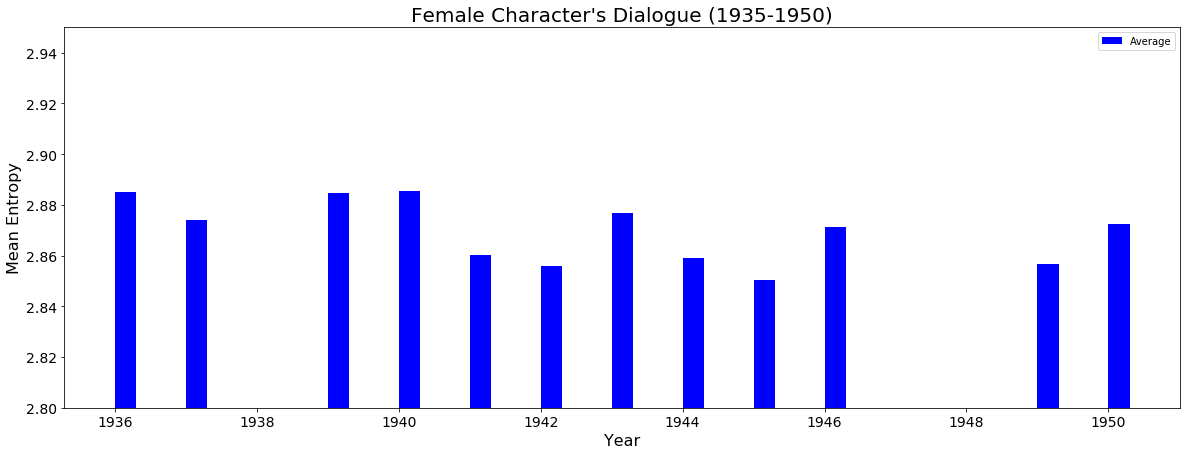

In [9]:
#a plot showing the average complexity of females' dialogues in movies from 1935 to 1950

width = 0.3
plt.figure(figsize=(20,7))
plt.bar(*zip(*avg_entropy), width, bottom=None, color='b', align='edge', data=None, label='Average')
plt.legend()
plt.tick_params(labelsize=14)
plt.ylim([2.8,2.95])
plt.ylabel('Mean Entropy', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('Female Character\'s Dialogue (1935-1950)', fontsize=20)
plt.show()

In [10]:
#calculate the correction between 'year' and 'entropy', of which being close to 1 is an indication of strong correlation
np.corrcoef(*zip(*avg_entropy))

#-0.514 shows a weak correction in the data

array([[ 1.        , -0.51432722],
       [-0.51432722,  1.        ]])

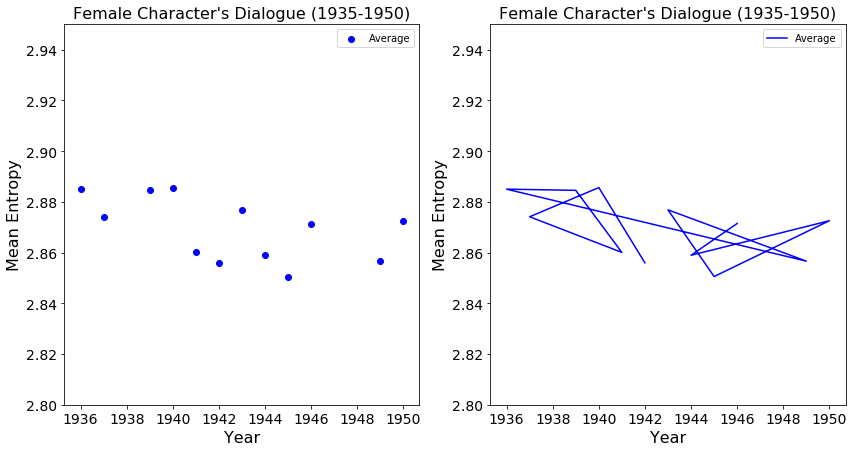

In [11]:
#visualize the data as scattered points
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.scatter(*zip(*avg_entropy), color='b', data=None, label='Average')
plt.legend()
plt.tick_params(labelsize=14)
plt.ylim([2.8,2.95])
plt.ylabel('Mean Entropy', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('Female Character\'s Dialogue (1935-1950)', fontsize=16)

#visualize the data as line graph
plt.subplot(1,2,2)
plt.plot(*zip(*avg_entropy), color='b', data=None, label='Average')
plt.legend()
plt.tick_params(labelsize=14)
plt.ylim([2.8,2.95])
plt.ylabel('Mean Entropy', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('Female Character\'s Dialogue (1935-1950)', fontsize=16)
plt.show()

###### Validity of 'mean entropy'

Mean-entropy includes entropy of minor characters, which are not neccessarily relevant in our study and lower the overall entropy of females' dialogue. Therefore, I decide the plot "Max-entropy" and "Mean-entropy" as a bar-chart side by side to see the difference.

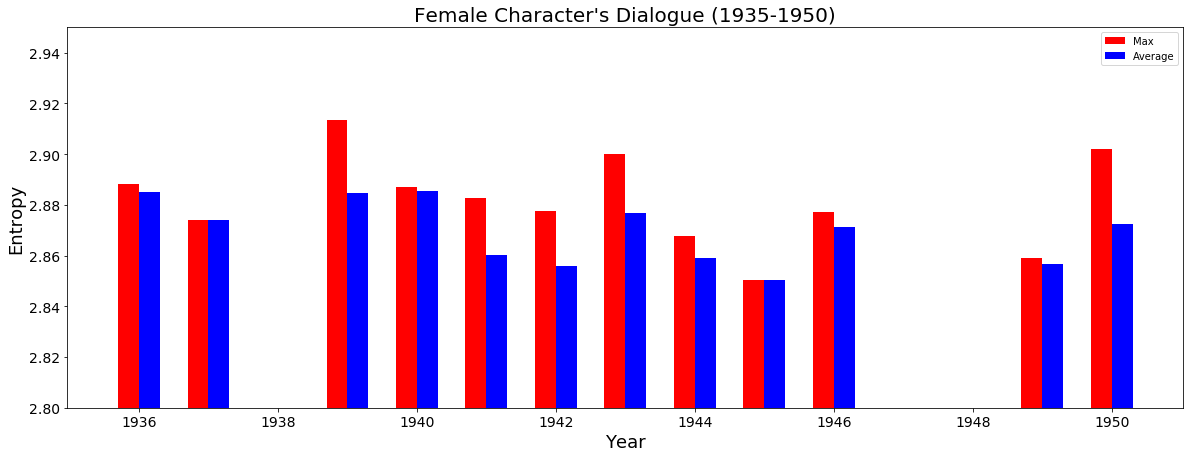

In [12]:
#Plot both 'max' and 'mean' entropy on a bar-chart
width = 0.3

plt.figure(figsize=(20,7))
plt.bar(*zip(*top_entropy), -width, bottom=None, color='r', align='edge', data=None, label='Max')
plt.bar(*zip(*avg_entropy), width, bottom=None, color='b', align='edge', data=None, label='Average')
plt.legend()
plt.tick_params(labelsize=14)
plt.ylim([2.8,2.95])
plt.ylabel('Entropy', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.title('Female Character\'s Dialogue (1935-1950)', fontsize=20)
plt.show()

In [13]:
#calculate the variance in each set of data, 'max' and 'mean', to see how spread the data is
entropy_var_mean = statistics.variance([entropy for year, entropy in avg_entropy])
print(entropy_var_mean)
entropy_var_max = statistics.variance([entropy for year, entropy in top_entropy])
print(entropy_var_max)

0.00015666662949797842
0.00032699373607124305


## selected period: 1995-2010, genres: 'Romance' and 'Drama'

All variables denoting with number '10' are related to this selected period, 1995 to 2010

The codes in the latter cells are a copy of the former cells with some modifications due to data.

In [14]:
#df_movie_10: a sliced dataframe selecting only movies produced between 1995 and 2010
df_movie_10 = df_title[(df_title.movie_year>=1995) & (df_title.movie_year<=2010)].loc[:,['movieID','movie_title','movie_year','genres']]

#movie_dict_10: a dictionary containing "year of product" as keys and "movie_ID" as values
#movie_dict_10 contains only "Romance" and "Drama" genre
movie_dict_10 = {} 
for year in df_movie_10.movie_year.unique():
    ls_movie = []
    curr_movie = df_movie_10[df_movie_10.movie_year == year]
    for idx in curr_movie.index:
        genres = curr_movie.loc[idx,'genres']
        movie_id = curr_movie.loc[idx, 'movieID']
        if type(genres) == list and ('Romance' in genres or 'Drama' in genres): #some data contains 'floats' as genres!
            ls_movie.append(movie_id)
    movie_dict_10[year] = ls_movie

In [15]:
#char_dict_10: a dictionary containing "year of production" as keys and sub-dictionaries as values.
#sub-dictionaries contains "movie_ID" as keys and corresponding "character_ID" as values
char_dict_10 = {}

for year in movie_dict_10.keys():
    sub_char_dict = {}
    for idn in movie_dict_10[year]:
        sub_char_dict[idn] = df_character[(df_character.movieID == idn) & (df_character.gender == 'F')].characterID.tolist()
    char_dict_10[year] = sub_char_dict

In [16]:
mean_entropy_dict_10 = {} #a dictionary containing "year_of_production" as keys and "average entropy" across all females as values
max_entropy_dict_10 = {} #a dictionary containing "year_of_production" as keys and "max entropy" of characters as values

for year in char_dict_10.keys(): #iterate through each year
    ls_movie_mean_entropy = [] #a list containing average entropy across all females in the movies produced in that year
    ls_movie_max_entropy = [] #a list containing only maximum entropy in the movies produced in that year
    
    for movieID in char_dict_10[year].values(): #iterate through each movie produced in that year
        ls_entropy = []
        
        for charID  in movieID: #iterate through all female characters in that movie
            quote = df_dialog[df_dialog.characterID == charID].dialog.tolist() #extract dialogue
            flat_quote = [val.strip(',.?:!-;').lower() for sublist in quote for val in sublist] #flatten "quote"
            archive = {} # a temporary dictionary containing all "words", spoken by character in that movie, as keys
            
            for word in flat_quote:
                archive[word] = tuple(flat_quote).count(word) #store word frequency as values
            del archive['']
            
            ls_value = []
            for value in archive.values():
                ls_value.append(int(value))
            entropy = 0
            total = sum(ls_value)
            
            for key in archive.keys():
                prob = int(archive[key])/total
                entropy += prob*math.log(prob)
            entropy = -entropy    #entropy for each character
            ls_entropy.append(entropy)
        
        if len(ls_entropy) != 0:      #some lists contain unknown variables of other types or empty
            avg_entropy = statistics.mean(ls_entropy) #average entropy across all females in that movie
            max_entropy = max(ls_entropy) #max entropy across females in that movie
        ls_movie_mean_entropy.append(avg_entropy)
        ls_movie_max_entropy.append(max_entropy)
    
    #choose only non-empty list
    if len(ls_movie_mean_entropy) != 0: 
        mean_entropy_dict_10[year] = ls_movie_mean_entropy
    if len(ls_movie_max_entropy) != 0:
        max_entropy_dict_10[year] = ls_movie_max_entropy

In [17]:
#a list of tuple containing 'year' and 'average entropy'
top_entropy_10 = [(year, max(max_entropy_dict_10[year])) for year in max_entropy_dict_10.keys()] 

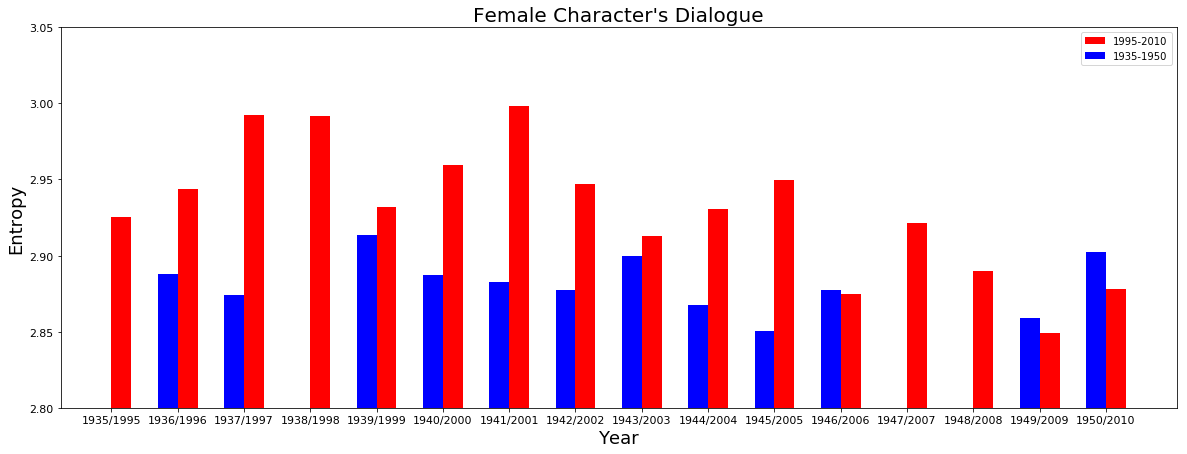

In [18]:
#Prepare data for create 'bar' plots
width = 0.3

def getkey(item):
    return item[0]

top_entropy_comyear = sorted([((str(year)+'/'+ str(year+60)), entropy) for year, entropy in top_entropy], key=getkey)
top_entropy_comyear_10 = sorted([((str(year-60)+'/'+ str(year)), entropy) for year, entropy in top_entropy_10], key=getkey)

plt.figure(figsize=(20,7))
plt.bar(*zip(*top_entropy_comyear_10), width, bottom=None, color='r', align='edge', data=None, label='1995-2010')
plt.bar(*zip(*top_entropy_comyear), -width, bottom=None, color='b', align='edge', data=None, label='1935-1950')
plt.legend()
plt.ylim([2.8,3.05])
plt.ylabel('Entropy', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.title('Female Character\'s Dialogue', fontsize=20)
plt.tick_params(labelsize=11)
plt.show()

In [19]:
past = [entropy for year, entropy in top_entropy]
present = [entropy for year, entropy in top_entropy_10]
_, p = stat.ranksums(past, present)
print('Wilcoxon Rank Sum test: \t  p = {0:6.4f}'.format(p) )

Wilcoxon Rank Sum test: 	  p = 0.0022


p = 0.0022 < 0.05 indicates that the median entropy from '1995-2010' is significantly higher than those from '1935-1950'. It tells us that females have more critical roles in movie industry, which can be seen through their richer dialogues. 

## Discussion and Conclusion

Over a short period of years, 1935-1950 and 1995-2010, the trend of females' dialogue entropy yeilds a poor correlation as shown earlier in the '1935-1950' scatter-plot, which is not enough to understand how our perception toward women in show industry or in the society in general has changed over the decade. In fact, this result is certainly expected, as we cannot expect the perception to change just over a decade in a large society, especially in the movie industry of 'Romance' and 'Drama' genre in which the stigmatism of feminism and masculism are heavily embedded. In fact, feminism and masculism are what 'Romance' and 'Drama' made up of anyway.

Nonetheless, an increase in females' dialogue complexity is more manifest by looking at the comparision bar-plot between 1935-1950 and 1995-2010. 1995-2010's reveals a higher complexity in women's dialogue as compared to 1935-1950's. The result of Wilcoxon's Rank Sum test gives the value of p = 0.0022 < 0.05, indicating that the median entropy from '1995-2010' is significantly higher than those from '1935-1950'. It tells us that females have more critical roles in movie industry, which can be seen through their richer dialogues.

So even though the intepretation of entropy analysis over a short range(about a decade) may be puzzling or incomprehensible, we could see that there's indeed a significant increase in female's role in the show business over a long term. Modern females' role become more critical and more influential in the movie. The implication of the growth is vast and huge, and which among them, a simple implication, perhaps, is that we learn to respect, understand and appreciate better the importance of women's contribution to the society, which is reflected through the movies as shown in this project.